# Data Extraction and Identification


## Screen extraction

In [ ]:
!pip install imutils
!pip install utils

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
DATA_SAVE_PATH = "/content/Datasets_digits/"
if not os.path.isdir(DATA_SAVE_PATH):
    print("Path ", DATA_SAVE_PATH, "has not formed")
    os.mkdir(DATA_SAVE_PATH)

for i in range(11):
    if not os.path.isdir(DATA_SAVE_PATH + str(i) +'/'):
        print("Path ", DATA_SAVE_PATH+ str(i) +'/', "has not formed")
        os.mkdir(DATA_SAVE_PATH+ str(i) +'/')

Path  /content/Datasets_digits/ has not formed
Path  /content/Datasets_digits/0/ has not formed
Path  /content/Datasets_digits/1/ has not formed
Path  /content/Datasets_digits/2/ has not formed
Path  /content/Datasets_digits/3/ has not formed
Path  /content/Datasets_digits/4/ has not formed
Path  /content/Datasets_digits/5/ has not formed
Path  /content/Datasets_digits/6/ has not formed
Path  /content/Datasets_digits/7/ has not formed
Path  /content/Datasets_digits/8/ has not formed
Path  /content/Datasets_digits/9/ has not formed
Path  /content/Datasets_digits/10/ has not formed


[[135 116]
 [491 116]
 [491 256]
 [135 256]]


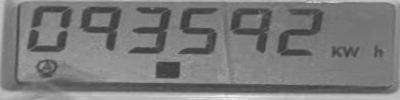

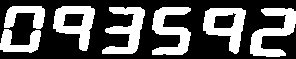

[0, 0, 0]


In [ ]:
import shutil
import os
import numpy as np
import imutils
import cv2
import scipy.spatial as sp
from skimage.measure import label, regionprops
import glob
import utils
#from utils.homofilt import HomomorphicFilter

import skimage.filters as ft
from google.colab.patches import cv2_imshow



class frameExtractor:

    def __init__(self, image=None, src_file_name=None, dst_file_name=None, return_image=False, output_shape =(400,100)):
        """
        Use this class to extract the frame/LCD screen from the image. This is our step 1 for image preprocessing.
        The final frame is extracted in grayscale.
        Note that it works for the "digital" case and can be used for the "analog" case, but it is more efficient on the "digital" case.
        :param image: RGB image (numpy array NxMx3) with a screen to extract. If image is None, the image will be extracted from src_filename
        :param src_file_name: filename to load the source image where the screen needs to be extracted (e.g. HQ_digital/0a07d2cff5beb0580bca191427e8cd6e1a0eb678.jpg)
        :param dst_file_name: filename to save the preprocessed image (e.g. HQ_digital_frame/0a07d2cff5beb0580bca191427e8cd6e1a0eb678.jpg
        :param return_image: a boolean, if True extractAndSave returns an image (np. array) / if False it just saves the image.
        :param output_shape: shape (in pxl) of the output image.
        """
        if image is None :
            self.image = cv2.imread(src_file_name)
        else :
            self.image = image
        self.dst_file_name = dst_file_name
        self.return_image = return_image
        self.output_shape = output_shape
        self.raw_frame = None
        self.frame = None
        self.sliced_frame = None


    def distance_from_center(self, rectangle):
        """
        Use this function to measure how far a rectangle is from the center of an image.
        Most of the time the frame is approx. in the middle of the picture.
        Note that the code works for shapes that are approx. rectangles.
        :param rectangle: a 4x2 array with the coordinates of each corner of the rectangle.
        :return: the distance (a float) between the center of the rectangle and the center of the picture.
        """
        center_rc = 0.5*(rectangle[0]+ rectangle[2])
        center_image = 0.5*np.array([self.image.shape[1],self.image.shape[0]])
        distance = np.linalg.norm(center_rc-center_image)
        return distance



    def sort_pts_clockwise(A):
        """
        Use this function to sort in clockwise order points in R^2.
        Credit: https://stackoverflow.com/questions/30088697/4-1-2-numpy-array-sort-clockwise
        :param A: a Nx2 array with the 2D coordinates of the points to sort.
        :return: a Nx2 array with the points sorted in clockwise order starting with the top-left point.
        """
        # Sort A based on Y(col-2) coordinates
        sortedAc2 = A[np.argsort(A[:,1]),:]
        # Get top two and bottom two points
        top2 = sortedAc2[0:2,:]
        bottom2 = sortedAc2[2:,:]
        # Sort top2 points to have the first row as the top-left one
        sortedtop2c1 = top2[np.argsort(top2[:,0]),:]
        top_left = sortedtop2c1[0,:]
        # Use top left point as pivot & calculate sq-euclidean dist against
        # bottom2 points & thus get bottom-right, bottom-left sequentially
        sqdists = sp.distance.cdist(top_left[None], bottom2, 'sqeuclidean')
        rest2 = bottom2[np.argsort(np.max(sqdists,0))[::-1],:]
        # Concatenate all these points for the final output
        return np.concatenate((sortedtop2c1,rest2),axis =0)


    def adjust_gamma(image, gamma=1.0):
        """
        Use this function to adjust illumination in an image.
        Credit: https://stackoverflow.com/questions/33322488/how-to-change-image-illumination-in-opencv-python
        :param image: A grayscale image (NxM int array in [0, 255]
        :param gamma: A positive float. If gamma<1 the image is darken / if gamma>1 the image is enlighten / if gamma=1 nothing happens.
        :return: the enlighten/darken version of image
        """
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
        return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))


    def frameDetection(self):
        """
        The core method of the class. Use it to extract the frame in the image.
        The extracted frame is in grayscale.
        The followed steps are :
            1. grayscale + smoothering + gamma to make the frame darker + binary threshold (rational = the frame is one of the darkest part in the picture).
            2. extract regions of "interest".
            3. heuristic to find a region of interest that is large enough, in the center of the picture and where length along x-axis > length along y-axis.
            4. make a perspective transform to crop the image and deal with perspective deformations.
        """
        self.image = imutils.resize(self.image, height=500)

        # Step 1: grayscale + smoothering + gamma to make the frame darker + binary threshold
        gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        gamma = frameExtractor.adjust_gamma(blurred, gamma=0.7)
        shapeMask = cv2.threshold(gamma, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        #shapeMask = gamma
        #cv2_imshow(shapeMask)
        # Step 2: extract regions of "interest".
        label_image = label(shapeMask)

        Cnt = None
        position = [0, 0, 0, 0]
        
        for region in regionprops(label_image):
            # Step 3: heuristic to find a region large enough, in the center & with length along x-axis > length along y-axis.
            minr, minc, maxr, maxc = region.bbox
            c = np.array([[minc, minr], [minc, maxr], [maxc, minr], [maxc, maxr]])

            if Cnt is None:
                Cnt = c
                position = [minr, minc, maxr, maxc]

            old_dist = self.distance_from_center(Cnt)
            new_dist = self.distance_from_center(c)

            Lx = maxc - minc
            Ly = maxr - minr

            c = frameExtractor.sort_pts_clockwise(c)

            if old_dist>new_dist and Ly<Lx and cv2.contourArea(c)>0.05*(shapeMask.shape[0]*shapeMask.shape[1]):
                displayCnt = c
                Cnt = c
                position = [minr, minc, maxr, maxc]

        Cnt = Cnt.reshape(4, 2)
        Cnt = frameExtractor.sort_pts_clockwise(Cnt)
        print(Cnt)


        # Step 4: Make a perspective transform to crop the image and deal with perspective deformations.
        try:
            # Crop the image around the region of interest (but keep a bit of distance with a 30px padding).
            # Darken + Binary threshold + rectangle detection.
            # If this technique fails, raise an error and use basic methods (except part).

            crop_img = self.image[max(0, position[0] - 30):min(position[2] + 30, self.image.shape[0]),\
                       max(0, position[1] - 30):min(self.image.shape[1], position[3] + 30)]

            crop_blurred = cv2.GaussianBlur(crop_img, (5, 5), 0)
            crop_gamma = frameExtractor.adjust_gamma(crop_blurred, gamma=0.4)
            crop_gray = cv2.cvtColor(crop_gamma, cv2.COLOR_BGR2GRAY)
            #cv2_imshow(crop_gray)
            crop_thresh = cv2.threshold(crop_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            cnts = cv2.findContours(crop_thresh.copy(), cv2.RETR_EXTERNAL,
                                    cv2.CHAIN_APPROX_SIMPLE)
            cnts = cnts[0] if imutils.is_cv2() else cnts[1]
            cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
            Cnt_bis = None

            for c in cnts:
                peri = cv2.arcLength(c, True)
                approx = cv2.approxPolyDP(c, 0.02 * peri, True)

                if len(approx) == 4:
                    Cnt_bis = approx
                    break

            if cv2.contourArea(Cnt_bis)<0.5*(crop_img.shape[0]*crop_img.shape[1]):
                raise ValueError("Couldn't find the box, so switching to ad hoc method.")
            
            Cnt_bis = Cnt_bis.reshape(4, 2)
            Cnt_bis = frameExtractor.sort_pts_clockwise(Cnt_bis)
            src_pts = Cnt_bis.copy()
            src_pts = src_pts.astype(np.float32)

            dst_pts = np.array([[0, 0], [400, 0], [400, 100], [0, 100]], dtype=np.float32)
            dst_pts = dst_pts.astype(np.float32)

            persp = cv2.getPerspectiveTransform(src_pts, dst_pts)
            warped = cv2.warpPerspective(crop_img, persp, (400, 100))
            cv2_imshow(warped)

        except:
            # More basic techniques that give +/- acceptable results when the first technique fails.

            src_pts = Cnt.copy()
            src_pts = src_pts.astype(np.float32)

            dst_pts = np.array([[0, 0], [400, 0], [400, 100], [0, 100]], dtype=np.float32)
            dst_pts = dst_pts.astype(np.float32)

            persp = cv2.getPerspectiveTransform(src_pts, dst_pts)
            warped = cv2.warpPerspective(gray, persp, (400, 100))
            cv2_imshow(warped)
        # Frame is extracted from the initial image in grayscale (not other processing done on the image).
        self.raw_frame = warped


    # TODO : check why they fail
    """
    http://www.amphident.de/en/blog/preprocessing-for-automatic-pattern-identification-in-wildlife-removing-glare.html
    http://people.csail.mit.edu/yichangshih/mywebsite/reflection.pdf
    http://news.mit.edu/2015/algorithm-removes-reflections-photos-0511
    """
    def preprocessFrame(self):
        """
        Final preprocessing that outputs a clean image 'cleaned_img' with more contrasts
        """
        try :
            gray = cv2.cvtColor(self.raw_frame, cv2.COLOR_BGR2GRAY)
        except :
            gray = self.raw_frame
        thresh = cv2.equalizeHist(gray)
        thresh = cv2.threshold(thresh, 45, 255, cv2.THRESH_BINARY_INV)[1]
        cleaned_img = cv2.dilate(thresh, None, iterations=1)
        self.frame = cleaned_img


    def sliceFrame(self):
        """
        Use this method to slice the frame and only keep the integer part (e.g. 123.45 becomes 123).
        Heuristic: comma is approx. at 8/13 of the image.
        :return:
        """
        stop_at = int(np.floor(self.output_shape[0]*10.5/13))

        start_at = int(self.output_shape[0]*0.9/13)
     
        stop_at_x = int(np.floor(self.output_shape[1]*7.7/13))
        self.sliced_frame = np.array(self.frame)[:stop_at_x,start_at:stop_at]


    def extractAndSaveFrame(self):
        """
        Use this method to
                1. detect and select the frame/screen.
                2. preprocessing to only keep numbers (and remove noise).
                3. slice the frame to only keep integer part.
                4. save the sliced frame in dst_file_name.
        :return: the extracted frame (np.array) if it was specified when instantiating the class.
        """
        self.frameDetection()
        self.preprocessFrame()
        self.sliceFrame()
        cv2.imwrite(self.dst_file_name, self.sliced_frame)
        cv2_imshow(self.sliced_frame)
        if self.return_image:
            return self.sliced_frame
        else:
            return



# --------------------- End of the class -----------------------------------



"""
A main function to preprocess all the images.
"""

if __name__ == "__main__":

    if os.path.exists('Datasets_frames/'):
        shutil.rmtree('Datasets_frames/')
        os.makedirs('Datasets_frames/')
    else:
        os.makedirs('Datasets_frames/')

    fail = [0, 0, 0]

    #for file in glob.glob('/content/456.jpg'):
    for file in glob.glob('/content/gdrive/MyDrive/img/img1.jpg'):  
        try:
            f = frameExtractor(image=None,
                               src_file_name=file,
                               dst_file_name='Datasets_frames/' + str(file).split('/')[-1],
                               return_image=False,
                               output_shape=(400, 100))
            f.extractAndSaveFrame()
        except:
            fail[0] += 1

    print(fail)

## Screen split

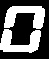

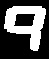

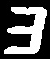

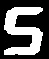

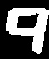

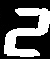

In [ ]:
import cv2
import os
import pandas as pd
import shutil


class cutDigits:

    def __init__(self, image=None, src_file_name=None, dst_folder_name='Datasets_digits', last_digit=6, labels=None):
        """
        The aim of this class is to extract digits from the frame-only preprocessed image.
        We to delimit digits by bounding boxes.
        We tried several approaches, but we present here the most successful one, a "dummy" yet efficient approach.
        :param image: RGB image (numpy array NxMx3) of a SLICED SCREEN. If image is None, the image will be extracted from src_filename
        :param src_file_name: filename of a SLICED SCREEN to load the source image (e.g. HQ_digital_preprocessing/0a07d2cff5beb0580bca191427e8cd6e1a0eb678.jpg)
        :param dst_folder_name: home FOLDERname where to save the extracted digits.
        :param last_digit: int, the number of digits you want to extract starting from the left (0 = no digits / 4 = all four digits).
        :param labels: list, list of labels corresponding to the image, e.g. if th image shows 123.45, the labels will be ['x',1,2,3].
        """
        if image is None :
            self.image = cv2.imread(src_file_name)
        else:
            self.image = image
        self.src_file_name = src_file_name
        self.dst_folder_name = dst_folder_name
        self.last_digit=last_digit
        self.labels = labels

        self.box_size = None
        self.boxes = []
        self.paths = []



    def get_bounding_box_dummy(self):
        """
        Use this method to get bounding boxes and extract numbers by dividing the area in 4 equal parts ("dummy" yet efficient approach).
        """

        self.boxes = []
        self.box_size = self.image.shape[1]/6

        for i in range(self.last_digit):
            inf = i * self.box_size
            sup = (i+1) * self.box_size
            self.boxes += [self.image[:, int(inf):int(sup)]]

        return self.boxes


    def save_to_folder(self) :
        """
        Use this method to save the extracted bounding boxes.
        """
        if self.dst_folder_name is None :
            return

        for i in range(len(self.boxes)):
            if self.labels :
                box = self.boxes[i]
                label = self.labels[i]
                src_file_name = self.src_file_name.split('/')[-1].split('.')[0]
                dst_file_name = 'Datasets_digits/%s/%s_%s.jpg' % (label, src_file_name, str(i))
                self.paths.append(dst_file_name)
                cv2.imwrite(dst_file_name, box)
                
            else:
                pass

            #else :
          #      box = self.boxes[i]
           #     src_file_name = self.src_file_name.split('/')[-1].split('.')[0]
            #    dst_file_name = 'Datasets_digits/%s/%s_%s.jpg' % ('missing_label', src_file_name, str(i))
            #    cv2.imwrite(dst_file_name, box)

    def get_paths(self):
        return self.paths

# --------------------- End of the class -----------------------------------

In [ ]:
!rm -rf '/content/Datasets_frames'

## Pytorch method

### Data Loading

In [ ]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

In [ ]:
#import all libraries to be used
import numpy as np
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import random

In [ ]:
# define the classes?
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
batch_size = 32
transform = transforms.Compose([transforms.Resize((180, 256)), 
                                  transforms.ToTensor()])
master_path = "/content/gdrive/MyDrive/img/Datasets_digits"
data_all = torchvision.datasets.ImageFolder(root = master_path, transform = transform)
total_len = len(data_all)
train_data, validation_data, test_data = torch.utils.data.random_split(data_all, [int(total_len*0.7), int(total_len*0.15), total_len-int(total_len*0.7)-int(total_len*0.15)])

#load the images
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                                num_workers=1, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                                num_workers=1, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size,
                                                num_workers=1, shuffle = True)


total = len(train_data) + len(test_data) + len(validation_data)
print("Image loading finished.")
print(len(train_data), "images in the training set, taking up {:.2f}".format(len(train_data)*100/total), "%")
print(len(test_data), "images in the testing set, taking up {:.2f}".format(len(test_data)*100/total) , "%")
print(len(validation_data), "images in the validation set, taking up {:.2f}".format(len(validation_data)*100/total), "%")

Image loading finished.
1330 images in the training set, taking up 69.96 %
286 images in the testing set, taking up 15.04 %
285 images in the validation set, taking up 14.99 %


### Classifier Definition

In [ ]:
# alexnet
import torchvision.models

alexNet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
#Artifical Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 4 * 7, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 256 * 4 * 7) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 13 * 22, 32)
        self.fc2 = nn.Linear(32, 11)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 13 * 22)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x

### Training

In [ ]:
def get_accuracy(model, data, train=False):
    correct = 0
    total = 0
    for imgs, labels in data:
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(ALNC(imgs))
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(net, train_data, val_data, batch_size=32, learning_rate=0.0002, num_epochs=30):
    ########################################################################
    # Train a classifier on different gestures
    target_classes = classes

    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    ########################################################################
    # Define the Loss function and optimizer
    #criterion = nn.BCEWithLogitsLoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,betas=(0.5,0.999))

    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    iters, losses, train_acc, val_acc = [], [], [], []

    print("Training start:")
    start_time = time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_data):
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            out = net(imgs)         # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(net, train_data, train=True)) # compute training accuracy 
        val_acc.append(get_accuracy(net, val_data, train=False))  # compute validation accuracy
        n += 1
          
        print(("Epoch {}: Train Accuracy: {}, Validation Accuracy: {} ").format(
                   epoch + 1,
                   train_acc[-1], 
                   val_acc[-1]))

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    print("Length of iters: ", len(iters))
    print("Length of train_acc: ", len(train_acc))
    print("Lenght of val_acc: ", len(val_acc))

    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
def train_alex(model, train_data, val_data, batch_size=32, learning_rate=0.0002, num_epochs=30):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,betas=(0.5,0.999))

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_data):
          
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            #### ALNC is alexNet.features (AlexNet without classifier) ####
            out = model(ALNC(imgs))             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole trainig set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
        train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        val_acc.append(get_accuracy(model, val_data, train=False))  # compute validation accuracy
        n += 1
        mini_b += 1
        print(("Epoch {}: Train Accuracy: {}, Validation Accuracy: {} ").format(epoch + 1,train_acc[-1],  val_acc[-1]))
        print("Epoch %d Finished. " % (epoch+1) ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, val_data, train=True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

CUDA is available!  Training on GPU ...
Epoch 1: Train Accuracy: 0.5, Validation Accuracy: 0.6140350877192983 
Epoch 1 Finished.  Time per Epoch:   7.52 s 
Epoch 2: Train Accuracy: 0.7222222222222222, Validation Accuracy: 0.6701754385964912 
Epoch 2 Finished.  Time per Epoch:   7.46 s 
Epoch 3: Train Accuracy: 0.8333333333333334, Validation Accuracy: 0.6912280701754386 
Epoch 3 Finished.  Time per Epoch:   7.44 s 
Epoch 4: Train Accuracy: 0.8333333333333334, Validation Accuracy: 0.7578947368421053 
Epoch 4 Finished.  Time per Epoch:   7.43 s 
Epoch 5: Train Accuracy: 0.7777777777777778, Validation Accuracy: 0.7789473684210526 
Epoch 5 Finished.  Time per Epoch:   7.45 s 
Epoch 6: Train Accuracy: 0.8888888888888888, Validation Accuracy: 0.7614035087719299 
Epoch 6 Finished.  Time per Epoch:   7.46 s 
Epoch 7: Train Accuracy: 0.8333333333333334, Validation Accuracy: 0.775438596491228 
Epoch 7 Finished.  Time per Epoch:   7.47 s 
Epoch 8: Train Accuracy: 0.8888888888888888, Validation Acc

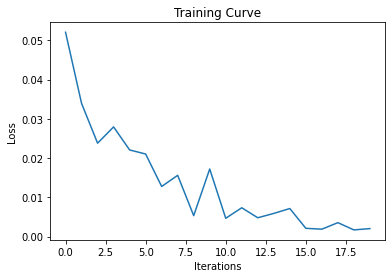

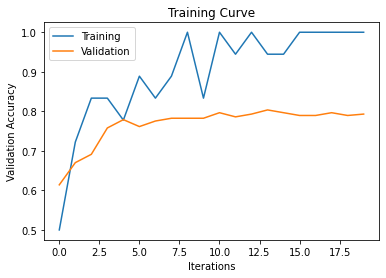

Final Training Accuracy: 0.7929824561403509
Final Validation Accuracy: 0.7929824561403509
Total time:   149.35 s  Time per Epoch:   7.47 s 


In [ ]:
use_cuda = True

model_t = ANNClassifier()
ALNC = alexNet.features

if use_cuda and torch.cuda.is_available():
    ALNC.cuda()
    model_t.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_alex(model_t, train_loader, validation_loader, num_epochs=20, learning_rate=0.0003)

In [ ]:
model_path = "/content/gdrive/MyDrive/img/model/model_2.pth"
torch.save(model_t.state_dict(), model_path)

In [ ]:
model = ANNClassifier()
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()

ANNClassifier(
  (fc1): Linear(in_features=7168, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

CUDA is available!  Training on GPU ...
Training start:
Epoch 1: Train Accuracy: 0.4447978191731031, Validation Accuracy: 0.38545454545454544 
Epoch 2: Train Accuracy: 0.5497501135847342, Validation Accuracy: 0.4690909090909091 
Epoch 3: Train Accuracy: 0.5942753293957292, Validation Accuracy: 0.5163636363636364 
Epoch 4: Train Accuracy: 0.5983643798273512, Validation Accuracy: 0.5054545454545455 
Epoch 5: Train Accuracy: 0.6378918673330305, Validation Accuracy: 0.5745454545454546 
Epoch 6: Train Accuracy: 0.6578827805542935, Validation Accuracy: 0.5672727272727273 
Epoch 7: Train Accuracy: 0.6624261699227624, Validation Accuracy: 0.5781818181818181 
Epoch 8: Train Accuracy: 0.7060427078600636, Validation Accuracy: 0.5745454545454546 
Epoch 9: Train Accuracy: 0.7469332121762835, Validation Accuracy: 0.5745454545454546 
Epoch 10: Train Accuracy: 0.7587460245343026, Validation Accuracy: 0.5563636363636364 
Finished Training
Total time elapsed: 6263.85 seconds
Length of iters:  690
Length

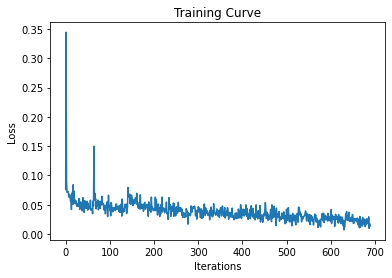

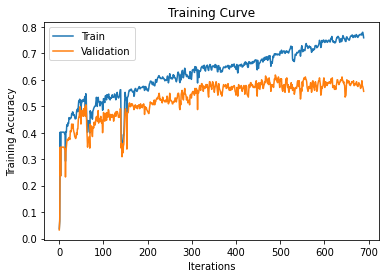

Final Training Accuracy: 0.7587460245343026
Final Validation Accuracy: 0.5563636363636364


In [ ]:
model1 = CNN()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  model1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_model(model1, train_loader, validation_loader, num_epochs=10)

In [ ]:
print("testing accuracy: ",get_accuracy(model_t, test_loader, train=False))

testing accuracy:  0.8041958041958042


### Result visualization

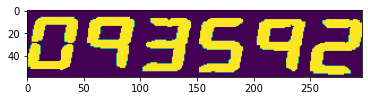

label = [0, 9, 3, 5, 9, 2]
reading = 93592


In [ ]:
img = Image.open("/content/Datasets_frames/img1.jpg")
plt.imshow(img)
plt.show()
labels = []
reading = 0

for p in paths:
    img = Image.open(p)

    img = transform(img)
    img = torch.unsqueeze(img, 0)

    output_p = model(ALNC(img.cuda()))
            
    #select index with maximum prediction score
    pred_p = output_p.max(1, keepdim=True)[1]
    labels.append(pred_p[0].item())
    reading = reading * 10 + int(pred_p[0].item())
print("label =", labels)
print("reading =",reading)

label =  2


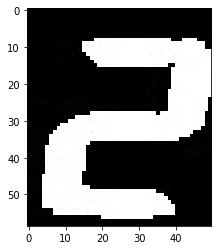

In [ ]:
from PIL import Image

produced_path = "/content/Datasets_digits"
img = Image.open("/content/Datasets_digits/2/img1_5.jpg")
plt.imshow(img)

img = transform(img)
img = torch.unsqueeze(img, 0)

output_p = model(ALNC(img.cuda()))
        
#select index with maximum prediction score
pred_p = output_p.max(1, keepdim=True)[1]
print("label = ", pred_p[0].item())

label =  0


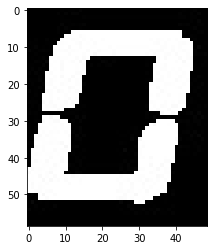

In [ ]:
from PIL import Image

img = Image.open("/content/Datasets_digits/0/img1_0.jpg")
plt.imshow(img)

img = transform(img)
img = torch.unsqueeze(img, 0)

output_p = model_t(ALNC(img.cuda()))
        
#select index with maximum prediction score
pred_p = output_p.max(1, keepdim=True)[1]
print("label = ", pred_p[0].item())

label =  3


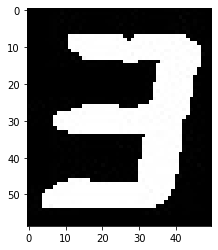

In [ ]:
from PIL import Image

img = Image.open("/content/Datasets_digits/3/img1_2.jpg")
plt.imshow(img)

img = transform(img)
img = torch.unsqueeze(img, 0)

output_p = model_t(ALNC(img.cuda()))
        
#select index with maximum prediction score
pred_p = output_p.max(1, keepdim=True)[1]
print("label = ", pred_p[0].item())

label =  5


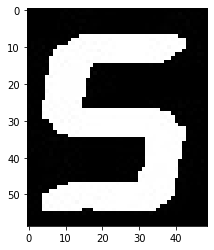

In [ ]:
from PIL import Image

img = Image.open("/content/Datasets_digits/5/img1_3.jpg")
plt.imshow(img)

img = transform(img)
img = torch.unsqueeze(img, 0)

output_p = model_t(ALNC(img.cuda()))
        
#select index with maximum prediction score
pred_p = output_p.max(1, keepdim=True)[1]
print("label = ", pred_p[0].item())

label =  9


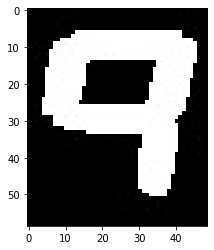

In [ ]:
from PIL import Image

img = Image.open("/content/Datasets_digits/9/img1_1.jpg")
plt.imshow(img)

img = transform(img)
img = torch.unsqueeze(img, 0)

output_p = model_t(ALNC(img.cuda()))
        
#select index with maximum prediction score
pred_p = output_p.max(1, keepdim=True)[1]
print("label = ", pred_p[0].item())


label =  8


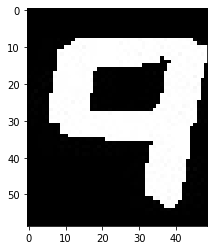

In [ ]:
img = Image.open("/content/Datasets_digits/9/img1_4.jpg")
plt.imshow(img)

img = transform(img)
img = torch.unsqueeze(img, 0)

output_p = model_t(ALNC(img.cuda()))
        
#select index with maximum prediction score
pred_p = output_p.max(1, keepdim=True)[1]
print("label = ", pred_p[0].item())

## Combined Functions

In [ ]:
!pip install imutils
!pip install utils

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

#import all libraries to be used
import numpy as np
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import random
from PIL import Image
    
import os
import torchvision.models

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import shutil
import os
import numpy as np
import imutils
import cv2
import scipy.spatial as sp
from skimage.measure import label, regionprops
import glob
import utils
#from utils.homofilt import HomomorphicFilter

import skimage.filters as ft
from google.colab.patches import cv2_imshow



class frameExtractor:

    def __init__(self, image=None, src_file_name=None, dst_file_name=None, return_image=False, output_shape =(400,100)):
        """
        Use this class to extract the frame/LCD screen from the image. This is our step 1 for image preprocessing.
        The final frame is extracted in grayscale.
        Note that it works for the "digital" case and can be used for the "analog" case, but it is more efficient on the "digital" case.
        :param image: RGB image (numpy array NxMx3) with a screen to extract. If image is None, the image will be extracted from src_filename
        :param src_file_name: filename to load the source image where the screen needs to be extracted (e.g. HQ_digital/0a07d2cff5beb0580bca191427e8cd6e1a0eb678.jpg)
        :param dst_file_name: filename to save the preprocessed image (e.g. HQ_digital_frame/0a07d2cff5beb0580bca191427e8cd6e1a0eb678.jpg
        :param return_image: a boolean, if True extractAndSave returns an image (np. array) / if False it just saves the image.
        :param output_shape: shape (in pxl) of the output image.
        """
        if image is None :
            self.image = cv2.imread(src_file_name)
        else :
            self.image = image
        self.dst_file_name = dst_file_name
        self.return_image = return_image
        self.output_shape = output_shape
        self.raw_frame = None
        self.frame = None
        self.sliced_frame = None


    def distance_from_center(self, rectangle):
        """
        Use this function to measure how far a rectangle is from the center of an image.
        Most of the time the frame is approx. in the middle of the picture.
        Note that the code works for shapes that are approx. rectangles.
        :param rectangle: a 4x2 array with the coordinates of each corner of the rectangle.
        :return: the distance (a float) between the center of the rectangle and the center of the picture.
        """
        center_rc = 0.5*(rectangle[0]+ rectangle[2])
        center_image = 0.5*np.array([self.image.shape[1],self.image.shape[0]])
        distance = np.linalg.norm(center_rc-center_image)
        return distance



    def sort_pts_clockwise(A):
        """
        Use this function to sort in clockwise order points in R^2.
        Credit: https://stackoverflow.com/questions/30088697/4-1-2-numpy-array-sort-clockwise
        :param A: a Nx2 array with the 2D coordinates of the points to sort.
        :return: a Nx2 array with the points sorted in clockwise order starting with the top-left point.
        """
        # Sort A based on Y(col-2) coordinates
        sortedAc2 = A[np.argsort(A[:,1]),:]
        # Get top two and bottom two points
        top2 = sortedAc2[0:2,:]
        bottom2 = sortedAc2[2:,:]
        # Sort top2 points to have the first row as the top-left one
        sortedtop2c1 = top2[np.argsort(top2[:,0]),:]
        top_left = sortedtop2c1[0,:]
        # Use top left point as pivot & calculate sq-euclidean dist against
        # bottom2 points & thus get bottom-right, bottom-left sequentially
        sqdists = sp.distance.cdist(top_left[None], bottom2, 'sqeuclidean')
        rest2 = bottom2[np.argsort(np.max(sqdists,0))[::-1],:]
        # Concatenate all these points for the final output
        return np.concatenate((sortedtop2c1,rest2),axis =0)


    def adjust_gamma(image, gamma=1.0):
        """
        Use this function to adjust illumination in an image.
        Credit: https://stackoverflow.com/questions/33322488/how-to-change-image-illumination-in-opencv-python
        :param image: A grayscale image (NxM int array in [0, 255]
        :param gamma: A positive float. If gamma<1 the image is darken / if gamma>1 the image is enlighten / if gamma=1 nothing happens.
        :return: the enlighten/darken version of image
        """
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
        return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))


    def frameDetection(self):
        """
        The core method of the class. Use it to extract the frame in the image.
        The extracted frame is in grayscale.
        The followed steps are :
            1. grayscale + smoothering + gamma to make the frame darker + binary threshold (rational = the frame is one of the darkest part in the picture).
            2. extract regions of "interest".
            3. heuristic to find a region of interest that is large enough, in the center of the picture and where length along x-axis > length along y-axis.
            4. make a perspective transform to crop the image and deal with perspective deformations.
        """
        self.image = imutils.resize(self.image, height=500)

        # Step 1: grayscale + smoothering + gamma to make the frame darker + binary threshold
        gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        gamma = frameExtractor.adjust_gamma(blurred, gamma=0.7)
        shapeMask = cv2.threshold(gamma, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        #shapeMask = gamma
        #cv2_imshow(shapeMask)
        # Step 2: extract regions of "interest".
        label_image = label(shapeMask)

        Cnt = None
        position = [0, 0, 0, 0]
        
        for region in regionprops(label_image):
            # Step 3: heuristic to find a region large enough, in the center & with length along x-axis > length along y-axis.
            minr, minc, maxr, maxc = region.bbox
            c = np.array([[minc, minr], [minc, maxr], [maxc, minr], [maxc, maxr]])

            if Cnt is None:
                Cnt = c
                position = [minr, minc, maxr, maxc]

            old_dist = self.distance_from_center(Cnt)
            new_dist = self.distance_from_center(c)

            Lx = maxc - minc
            Ly = maxr - minr

            c = frameExtractor.sort_pts_clockwise(c)

            if old_dist>new_dist and Ly<Lx and cv2.contourArea(c)>0.05*(shapeMask.shape[0]*shapeMask.shape[1]):
                displayCnt = c
                Cnt = c
                position = [minr, minc, maxr, maxc]

        Cnt = Cnt.reshape(4, 2)
        Cnt = frameExtractor.sort_pts_clockwise(Cnt)
        print(Cnt)


        # Step 4: Make a perspective transform to crop the image and deal with perspective deformations.
        try:
            # Crop the image around the region of interest (but keep a bit of distance with a 30px padding).
            # Darken + Binary threshold + rectangle detection.
            # If this technique fails, raise an error and use basic methods (except part).

            crop_img = self.image[max(0, position[0] - 30):min(position[2] + 30, self.image.shape[0]),\
                       max(0, position[1] - 30):min(self.image.shape[1], position[3] + 30)]

            crop_blurred = cv2.GaussianBlur(crop_img, (5, 5), 0)
            crop_gamma = frameExtractor.adjust_gamma(crop_blurred, gamma=0.4)
            crop_gray = cv2.cvtColor(crop_gamma, cv2.COLOR_BGR2GRAY)
            #cv2_imshow(crop_gray)
            crop_thresh = cv2.threshold(crop_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            cnts = cv2.findContours(crop_thresh.copy(), cv2.RETR_EXTERNAL,
                                    cv2.CHAIN_APPROX_SIMPLE)
            cnts = cnts[0] if imutils.is_cv2() else cnts[1]
            cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
            Cnt_bis = None

            for c in cnts:
                peri = cv2.arcLength(c, True)
                approx = cv2.approxPolyDP(c, 0.02 * peri, True)

                if len(approx) == 4:
                    Cnt_bis = approx
                    break

            if cv2.contourArea(Cnt_bis)<0.5*(crop_img.shape[0]*crop_img.shape[1]):
                raise ValueError("Couldn't find the box, so switching to ad hoc method.")
            
            Cnt_bis = Cnt_bis.reshape(4, 2)
            Cnt_bis = frameExtractor.sort_pts_clockwise(Cnt_bis)
            src_pts = Cnt_bis.copy()
            src_pts = src_pts.astype(np.float32)

            dst_pts = np.array([[0, 0], [400, 0], [400, 100], [0, 100]], dtype=np.float32)
            dst_pts = dst_pts.astype(np.float32)

            persp = cv2.getPerspectiveTransform(src_pts, dst_pts)
            warped = cv2.warpPerspective(crop_img, persp, (400, 100))
            cv2_imshow(warped)

        except:
            # More basic techniques that give +/- acceptable results when the first technique fails.

            src_pts = Cnt.copy()
            src_pts = src_pts.astype(np.float32)

            dst_pts = np.array([[0, 0], [400, 0], [400, 100], [0, 100]], dtype=np.float32)
            dst_pts = dst_pts.astype(np.float32)

            persp = cv2.getPerspectiveTransform(src_pts, dst_pts)
            warped = cv2.warpPerspective(gray, persp, (400, 100))
            cv2_imshow(warped)
        # Frame is extracted from the initial image in grayscale (not other processing done on the image).
        self.raw_frame = warped


    # TODO : check why they fail
    """
    http://www.amphident.de/en/blog/preprocessing-for-automatic-pattern-identification-in-wildlife-removing-glare.html
    http://people.csail.mit.edu/yichangshih/mywebsite/reflection.pdf
    http://news.mit.edu/2015/algorithm-removes-reflections-photos-0511
    """
    def preprocessFrame(self):
        """
        Final preprocessing that outputs a clean image 'cleaned_img' with more contrasts
        """
        try :
            gray = cv2.cvtColor(self.raw_frame, cv2.COLOR_BGR2GRAY)
        except :
            gray = self.raw_frame
        thresh = cv2.equalizeHist(gray)
        thresh = cv2.threshold(thresh, 45, 255, cv2.THRESH_BINARY_INV)[1]
        cleaned_img = cv2.dilate(thresh, None, iterations=1)
        self.frame = cleaned_img


    def sliceFrame(self):
        """
        Use this method to slice the frame and only keep the integer part (e.g. 123.45 becomes 123).
        Heuristic: comma is approx. at 8/13 of the image.
        :return:
        """
        stop_at = int(np.floor(self.output_shape[0]*10.5/13))

        start_at = int(self.output_shape[0]*0.9/13)
     
        stop_at_x = int(np.floor(self.output_shape[1]*7.7/13))
        self.sliced_frame = np.array(self.frame)[:stop_at_x,start_at:stop_at]


    def extractAndSaveFrame(self):
        """
        Use this method to
                1. detect and select the frame/screen.
                2. preprocessing to only keep numbers (and remove noise).
                3. slice the frame to only keep integer part.
                4. save the sliced frame in dst_file_name.
        :return: the extracted frame (np.array) if it was specified when instantiating the class.
        """
        self.frameDetection()
        self.preprocessFrame()
        self.sliceFrame()
        cv2.imwrite(self.dst_file_name, self.sliced_frame)
        cv2_imshow(self.sliced_frame)
        if self.return_image:
            return self.sliced_frame
        else:
            return



# --------------------- End of the class -----------------------------------

In [ ]:
import cv2
import os
import pandas as pd
import shutil


class cutDigits:

    def __init__(self, image=None, src_file_name=None, dst_folder_name='Datasets_digits', last_digit=6, labels=None):
        """
        The aim of this class is to extract digits from the frame-only preprocessed image.
        We to delimit digits by bounding boxes.
        We tried several approaches, but we present here the most successful one, a "dummy" yet efficient approach.
        :param image: RGB image (numpy array NxMx3) of a SLICED SCREEN. If image is None, the image will be extracted from src_filename
        :param src_file_name: filename of a SLICED SCREEN to load the source image (e.g. HQ_digital_preprocessing/0a07d2cff5beb0580bca191427e8cd6e1a0eb678.jpg)
        :param dst_folder_name: home FOLDERname where to save the extracted digits.
        :param last_digit: int, the number of digits you want to extract starting from the left (0 = no digits / 4 = all four digits).
        :param labels: list, list of labels corresponding to the image, e.g. if th image shows 123.45, the labels will be ['x',1,2,3].
        """
        if image is None :
            self.image = cv2.imread(src_file_name)
        else:
            self.image = image
        self.src_file_name = src_file_name
        self.dst_folder_name = dst_folder_name
        self.last_digit=last_digit
        self.labels = labels

        self.box_size = None
        self.boxes = []
        self.paths = []



    def get_bounding_box_dummy(self):
        """
        Use this method to get bounding boxes and extract numbers by dividing the area in 4 equal parts ("dummy" yet efficient approach).
        """

        self.boxes = []
        self.box_size = self.image.shape[1]/6

        for i in range(self.last_digit):
            inf = i * self.box_size
            sup = (i+1) * self.box_size
            self.boxes += [self.image[:, int(inf):int(sup)]]

        return self.boxes


    def save_to_folder(self) :
        """
        Use this method to save the extracted bounding boxes.
        """
        if self.dst_folder_name is None :
            return

        for i in range(len(self.boxes)):
            if self.labels :
                box = self.boxes[i]
                label = self.labels[i]
                src_file_name = self.src_file_name.split('/')[-1].split('.')[0]
                dst_file_name = 'Datasets_digits/%s/%s_%s.jpg' % (label, src_file_name, str(i))
                self.paths.append(dst_file_name)
                cv2.imwrite(dst_file_name, box)
                
            else:
                pass

            #else :
          #      box = self.boxes[i]
           #     src_file_name = self.src_file_name.split('/')[-1].split('.')[0]
            #    dst_file_name = 'Datasets_digits/%s/%s_%s.jpg' % ('missing_label', src_file_name, str(i))
            #    cv2.imwrite(dst_file_name, box)

    def get_paths(self):
        return self.paths

# --------------------- End of the class -----------------------------------

In [ ]:
#Artifical Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 4 * 7, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 256 * 4 * 7) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def OCR(img_path):
    print("Original Image: ")
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    labels = ['10','10', '10', '10', '10','10'] # label 10 refers to unknown label

    if os.path.exists('Datasets_frames/'):
        shutil.rmtree('Datasets_frames/')
        os.makedirs('Datasets_frames/')
    else:
        os.makedirs('Datasets_frames/')

    DATA_SAVE_PATH = "/content/Datasets_digits/"
    if not os.path.isdir(DATA_SAVE_PATH):
        print("Path ", DATA_SAVE_PATH, "has not formed")
        os.mkdir(DATA_SAVE_PATH)

    for i in range(11):
        if not os.path.isdir(DATA_SAVE_PATH + str(i) +'/'):
            print("Path ", DATA_SAVE_PATH+ str(i) +'/', "has not formed")
            os.mkdir(DATA_SAVE_PATH+ str(i) +'/')

    fail = [0, 0, 0]
    print("Screen Extract:")
    # Extract the screen
    for file in glob.glob(img_path):  
        try:
            f = frameExtractor(image=None,
                               src_file_name=file,
                               dst_file_name='Datasets_frames/' + str(file).split('/')[-1],
                               return_image=False,
                               output_shape=(400, 100))
            f.extractAndSaveFrame()
        except:
            fail[0] += 1

    print("Screen reading splitted into digits:")
    df = cv2.imread(img_path)
    for i in range(1):
        file_name = 'digits_'
        src_file_name = "Datasets_frames/%s" % file_name

        try :
            cutter = cutDigits(src_file_name="/content/Datasets_frames/img1.jpg", labels=labels)
            
            images_x = cutter.get_bounding_box_dummy()
            cutter.save_to_folder()
            paths = cutter.get_paths()

            for img in images_x:
                cv2_imshow(img)

        except :
            fail[1] += 1

    model_path = "/content/gdrive/MyDrive/img/model/model_2.pth"
    transform = transforms.Compose([transforms.Resize((180, 256)), 
                                  transforms.ToTensor()])
    
    print("Digit Recognition:")
    img = Image.open("/content/Datasets_frames/img1.jpg")
    plt.imshow(img)
    plt.show()
    
    alexNet = torchvision.models.alexnet(pretrained=True)
    
    ALNC = alexNet.features
    ALNC.cuda()

    model = ANNClassifier()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.cuda()

    labels = []
    reading = 0

    for p in paths:
        img = Image.open(p)

        img = transform(img)
        img = torch.unsqueeze(img, 0)

        output_p = model(ALNC(img.cuda()))
                
        #select index with maximum prediction score
        pred_p = output_p.max(1, keepdim=True)[1]
        labels.append(pred_p[0].item())
        reading = reading * 10 + int(pred_p[0].item())

    print("label =", labels)
    print("reading =",reading)


    

Original Image: 


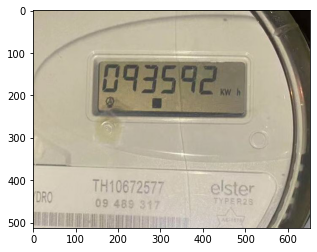

Path  /content/Datasets_digits/ has not formed
Path  /content/Datasets_digits/0/ has not formed
Path  /content/Datasets_digits/1/ has not formed
Path  /content/Datasets_digits/2/ has not formed
Path  /content/Datasets_digits/3/ has not formed
Path  /content/Datasets_digits/4/ has not formed
Path  /content/Datasets_digits/5/ has not formed
Path  /content/Datasets_digits/6/ has not formed
Path  /content/Datasets_digits/7/ has not formed
Path  /content/Datasets_digits/8/ has not formed
Path  /content/Datasets_digits/9/ has not formed
Path  /content/Datasets_digits/10/ has not formed
Screen Extract:
[[135 116]
 [491 116]
 [491 256]
 [135 256]]


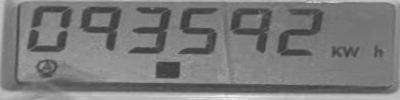

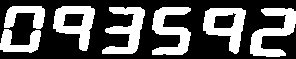

Screen reading splitted into digits:


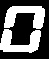

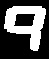

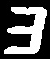

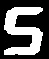

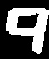

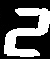

Digit Recognition:


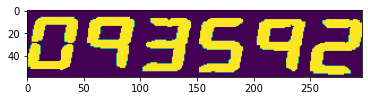

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

label = [0, 9, 3, 5, 9, 2]
reading = 93592


In [ ]:
OCR('/content/gdrive/MyDrive/img/img1.jpg')